In [1]:
import pandas as pd

# 读取CSV文件
df = pd.read_csv('molecule_results_n.csv')

# 按 reward 降序排序
df_sorted = df.sort_values(by='reward', ascending=False)

# 去除重复 SMILES（保留分数最高的那一条）
df_unique = df_sorted.drop_duplicates(subset='smiles', keep='first')

# 取前 1 万条
top_10k = df_unique.head(10000)

# 保存为新文件
top_10k.to_csv('molecule_top10k_n.csv', index=False)

print(f"去重后共有 {len(df_unique)} 个唯一分子，已保存前 {len(top_10k)} 个高分分子到 molecule_top10k_n.csv")


去重后共有 159396 个唯一分子，已保存前 10000 个高分分子到 molecule_top10k_n.csv


In [2]:
#随机取1W条
import pandas as pd

# 读取CSV文件
df = pd.read_csv('molecule_results_n.csv')

# 按 reward 降序排序
df_sorted = df.sort_values(by='reward', ascending=False)

# 去除重复 SMILES（保留分数最高的那一条）
df_unique = df_sorted.drop_duplicates(subset='smiles', keep='first')

# 随机取 1 万条（如果数据不足1万条，则取全部）
if len(df_unique) >= 30000:
    # 使用 sample 方法随机抽取
    random_10k = df_unique.sample(n=30000, random_state=42)  # random_state 保证可重复性
else:
    random_10k = df_unique
    print(f"警告：去重后只有 {len(df_unique)} 个唯一分子，将全部取出")

# 保存为新文件
random_10k.to_csv('molecule_random10k.csv', index=False)

print(f"去重后共有 {len(df_unique)} 个唯一分子，已随机抽取 {len(random_10k)} 个分子到 molecule_random10k.csv")

去重后共有 159396 个唯一分子，已随机抽取 30000 个分子到 molecule_random10k.csv


In [3]:
from rdkit import Chem
import pandas as pd

df = pd.read_csv('molecule_random10k.csv')

def replace_placeholders_with_h(smiles: str) -> str:
    try:
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None

        mol = Chem.RWMol(mol)
        replace_indices = [a.GetIdx() for a in mol.GetAtoms()
                           if a.GetSymbol() == '*' or a.GetAtomicNum() == 0]

        # 替换占位符为氢原子（暂时显式）
        for idx in reversed(replace_indices):
            mol.ReplaceAtom(idx, Chem.Atom(1))  # atomic number 1 = H

        mol = mol.GetMol()
        Chem.SanitizeMol(mol)

        # 移除所有显式氢，让 RDKit 自动隐式化
        mol_noH = Chem.RemoveHs(mol)

        # 再次标准化，输出不带 [H] 的 SMILES
        smiles_clean = Chem.MolToSmiles(mol_noH, isomericSmiles=True)
        return smiles_clean
    except Exception:
        return None

df['smiles_clean'] = df['smiles'].apply(replace_placeholders_with_h)
df = df.dropna(subset=['smiles_clean'])
df.to_csv('molecule_10k_clean_one_step.csv', index=False)

print(f"已生成 molecule_10k_clean_one_step.csv，共 {len(df)} 条合法分子（无显式 [H]）")


已生成 molecule_10k_clean_one_step.csv，共 30000 条合法分子（无显式 [H]）


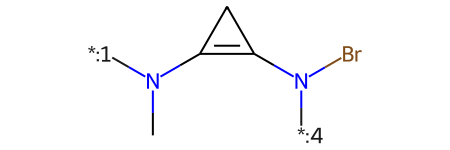

In [13]:
from rdkit import Chem
import pandas as pd
df = pd.read_csv('molecule_top10k_clean.csv')
smiles = df['smiles_clean'][0]
smiles_original = df['smiles'][0]
mol = Chem.MolFromSmiles(smiles)
mol_original = Chem.MolFromSmiles(smiles_original)
mol
mol_original